# Training and Evaluating LDA Models

In [19]:
import warnings

# Ignore warnings
warnings.filterwarnings('ignore')


## Training

This is the the heart of our LDA Pipeline. After loading the preprocessed data from [the previous notebook](02.2_LDA-Preprocessing.ipynb), we will use the sklearn implementation of LDA to train our model. We will also use the GridSearchCV class to find the best hyperparameters for our model.

Other popular Python-Implementations of LDA include [gensim](https://radimrehurek.com/gensim/models/ldamodel.html) and [lda](https://pypi.org/project/lda/).

All of these adhere to a very similar API and differ only in minor details. Gensim in particular is a very popular library for topic modeling with a lot of additional functionality, so you might want to check it out.

### Loading Preprocessed Data

In [20]:
import json

with open('../data/articles/train.preprocessed.json', 'r') as f:
    data = json.load(f)


### Setting up the Pipeline

The sklearn LDA-implementation ingests a document-term-matrix (DTM) as input. This is a matrix where each row represents a document and each column represents a term. The values in the matrix represent the frequency of the term in the document.

To create a DTM from our data, we will use the gensim dictionary. This class takes a list of strings as input, generates a vocabulary as an intermediate step, and outputs a DTM.
It allows us to prune that vocabulary by setting a minimum and maximum document frequency for the terms in the vocabulary. This is useful to remove very rare terms that are likely to be typos or very common terms that are unlikely to be informative.

In [21]:
from gensim.corpora import Dictionary

# Create a dictionary representation of the documents and filter out frequent and rare words.
dictionary = Dictionary(data)
dictionary.filter_extremes(no_below=30, no_above=0.85)

# Build the Document Term Matrix (DTM)
dtm = [dictionary.doc2bow(doc) for doc in data]

N, V = len(dtm), len(dictionary)
print("Found a vocabulary of {} unique terms in {} documents".format(V, N))


Found a vocabulary of 4442 unique terms in 2977 documents


### Training the Model

To perform LDA, we need to choose three hyperparameters. The first is the number of topics we want to find, $K$. The second is the $\alpha$ parameter, which controls the sparsity of the document-topic matrix. The third is the $\eta$ parameter, which controls the sparsity of the topic-term matrix. While the latter two can be omitted and will, sensibly be set to $\alpha = \eta = \frac{1}{n_{topics}}$, there is no default for the number of topics.

We know there are four topics in our first dataset. However, as this is a rather unusual, we will begin by setting $K=10$.

In [4]:
from gensim.models import LdaMulticore


def train_lda_model(dtm, K, *, alpha="symmetric", eta=None):
    lda_model = LdaMulticore(corpus=dtm, num_topics=K, alpha=alpha, eta=eta)
    return lda_model


lda_model = train_lda_model(dtm, 10)


### Visualizing the Topics

pyLDAvis is the most common Python library for visualizing LDA models. It is based on the R package LDAvis, which is described in [this paper](https://nlp.stanford.edu/events/illvi2014/papers/sievert-illvi2014.pdf).

The visualization consists of two parts. The left part shows a two-dimensional projection of the topics. The right part shows the top 30 terms for the selected topic. The size of the terms is proportional to the frequency of the term in the corpus. The distance between the terms is proportional to the distance between the terms in the topic-term matrix.

We set multidimensional-scaling (MDS) to use t-SNE, which yields a visually more appealing bubble-distribution than the default PCA.

In [5]:
import pyLDAvis
import pyLDAvis.gensim

pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(lda_model, dtm, dictionary, mds='tsne')


PreparedData(topic_coordinates=               x          y  topics  cluster       Freq
topic                                                  
3     -26.116421 -69.369362       1        1  13.794676
8      10.287889 -37.925224       2        1  13.618960
5     -57.118359 -24.471048       3        1  13.446045
1     -15.683702   0.204071       4        1  10.540762
2     -44.698902  37.464119       5        1   9.400843
7      30.381805   3.692037       6        1   8.984560
0      10.641542  50.747612       7        1   8.361696
9      36.447609 -77.395905       8        1   7.828207
6      67.720390 -30.424929       9        1   7.459474
4      68.387085  30.961025      10        1   6.564777, topic_info=            Term         Freq        Total Category  logprob  loglift
30             I  8839.000000  8839.000000  Default  30.0000  30.0000
338         year  7453.000000  7453.000000  Default  29.0000  29.0000
318         time  4217.000000  4217.000000  Default  28.0000  28.0000
2318    Facebook  1453.000000  1453.000000  Default  27.0000  27.0000
164         find  2740.000000  2740.000000  Default  26.0000  26.0000
...          ...          ...          ...      ...      ...      ...
185         high   155.500589  2048.085837  Topic10  -6.0279   0.1454
553   government   164.037762  2363.812197  Topic10  -5.9744   0.0555
842         week   158.127837  2172.236913  Topic10  -6.0111   0.1033
835         team   156.080999  2120.725290  Topic10  -6.0241   0.1143
425         know   157.744957  2946.848931  Topic10  -6.0135  -0.2041

[763 rows x 6 columns], token_table=      Topic      Freq          Term
term                               
2763      1  0.108041  2014krasnaya
2763      2  0.064825  2014krasnaya
2763      3  0.302516  2014krasnaya
2763      4  0.064825  2014krasnaya
2763      5  0.129650  2014krasnaya
...     ...       ...           ...
338       6  0.040251          year
338       7  0.115654          year
338       8  0.050582          year
338       9  0.068560          year
338      10  0.068426          year

[4550 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 9, 6, 2, 3, 8, 1, 10, 7, 5])

## Evaluation

Evaluating topic models is a difficult task. 
Typically, there are no ground truth labels, so we cannot use metrics like precision and recall. 
Instead, besides manual inspection, we usually have to rely on metrics that measure the coherence of the topics. 
These metrics are based on the assumption that a good topic model will produce topics that are both distinct and human interpretable.

### Coherence

Coherence is a measure of the semantic similarity of the terms in a topic. A good coherence score indicates that the terms within a topic are more probable to coocure within the topic than outside of it.

To generate the optimal number of topics, we have to compute the LDA-Model for every number of topics we are interested in. Usually, one starts by computing the model for a small number of topics and then increases the number of topics until the coherence score starts to decrease.

In [35]:
from tqdm import tqdm
from gensim.models import CoherenceModel

number_of_topics = [4, 8, 16, 32]
coherence_scores = []

pbar = tqdm(number_of_topics, ncols=100)
for K in pbar:
    pbar.set_description("Computing LDA")
    lda_model = train_lda_model(dtm, K)

    pbar.set_description("Computing Coherence")
    cm_umass = CoherenceModel(model=lda_model, corpus=dtm,
                              dictionary=dictionary, coherence='u_mass')

    coherence_scores.append(cm_umass.get_coherence())


Computing Coherence: 100%|████████████████████████████████████████████| 4/4 [00:18<00:00,  4.59s/it]


We plot the coherence score for the different numbers of topics and choose the number of topics that maximizes the coherence score.

Text(0, 0.5, 'Coherence Score')

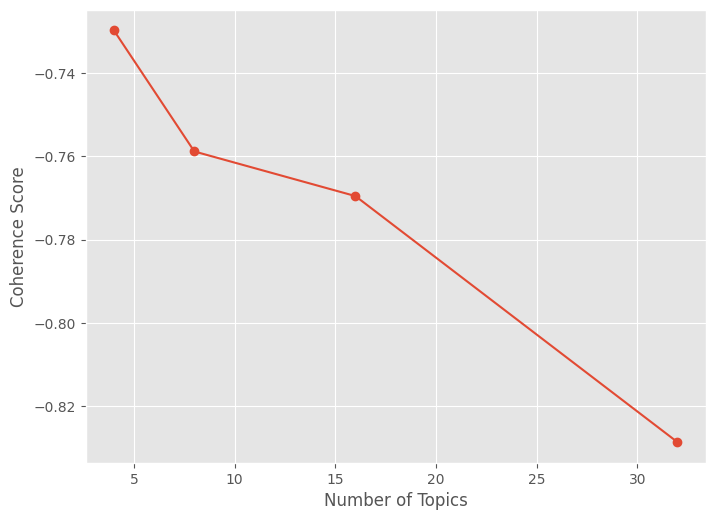

In [36]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

fig, ax = plt.subplots(figsize=(8, 6), dpi=100)
ax.plot(number_of_topics, coherence_scores, marker='o')

ax.set_xlabel("Number of Topics")
ax.set_ylabel("Coherence Score")


This graph fits our previous knowledge: The first dataset has four topics, which also maximizes the coherence score.

Note, that there are multiple ways to measure coherence. The gensim library offers several of them. We will use the UMass coherence score, which is the fastest to compute. Other prominent coherence measures include the UCI coherence score and the $c_v$ coherence score. For more information, check out [this paper](https://svn.aksw.org/papers/2015/WSDM_Topic_Evaluation/public.pdf).

### Grid-Search for $\alpha$ and $\eta$

While the number of topics is the most important hyperparameter, the $\alpha$ and $\eta$ parameters can also have a significant impact on the quality of the topics.

To find the optimal values for these parameters, we will use the GridSearchCV class. This class takes a model and a dictionary of hyperparameters as input and computes the model for all combinations of the hyperparameters. It then returns the model with the best score.

In theory, one should optimize all three parameters at once. However, this is computationally very expensive. Therefore, we will fix the number of topics to the optimal value we found in the previous step and only optimize $\alpha$ and $\eta$.

In [59]:
import numpy as np

array_alpha = np.logspace(-2, 0, 4, base=2)
array_eta = np.logspace(-2, 0, 4, base=2)
results = np.zeros((len(array_alpha), len(array_eta)))

K = 4


def compute_coherence(alpha, eta):
    lda_model = LdaMulticore(dtm, K, alpha=alpha, eta=eta)
    cm_umass = CoherenceModel(model=lda_model, corpus=dtm,
                              dictionary=dictionary, coherence='u_mass')
    return cm_umass.get_coherence()


for i, alpha in tqdm(enumerate(array_alpha), ncols=100, position=0, total=len(array_alpha)):
    for j, eta in tqdm(enumerate(array_eta), ncols=100, position=1, leave=False, total=len(array_eta)):
        results[i, j] = compute_coherence(alpha, eta)


100%|█████████████████████████████████████████████████████████████████| 4/4 [01:01<00:00, 15.46s/it]


We can now plot the results of the grid-search. The plot shows the coherence score for the different values of $\alpha$ and $\eta$.
The optimal values are the ones that maximize the coherence score.

In [1]:
optimal = np.unravel_index(np.argmax(results), results.shape)
optimal_parameters = (array_alpha[optimal[0]], array_eta[optimal[1]])

print("Optimal parameters: alpha={}, eta={}".format(*optimal_parameters))

plt.imshow(results, cmap='RdBu', interpolation='nearest')
plt.grid(False)


NameError: name 'np' is not defined

### Exploring the Optimal Model

In [37]:
K = 4
lda_model = train_lda_model(
    dtm, K, alpha=optimal_parameters[0], eta=optimal_parameters[1])

pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(lda_model, dtm, dictionary, mds='tsne')


PreparedData(topic_coordinates=               x           y  topics  cluster       Freq
topic                                                   
0     -84.698318   -4.284818       1        1  34.828347
3      23.969799  -64.942490       2        1  24.150054
1     -24.041286  104.384781       3        1  21.974277
2      84.627121   43.728096       4        1  19.047322, topic_info=         Term         Freq        Total Category  logprob  loglift
33          I  8653.000000  8653.000000  Default  30.0000  30.0000
734    people  4968.000000  4968.000000  Default  29.0000  29.0000
319     study  2106.000000  2106.000000  Default  28.0000  28.0000
2443  vaccine  1288.000000  1288.000000  Default  27.0000  27.0000
200   include  2863.000000  2863.000000  Default  26.0000  26.0000
...       ...          ...          ...      ...      ...      ...
99       come   481.653728  2833.188906   Topic4  -6.0061  -0.1137
230     month   436.345447  2261.812694   Topic4  -6.1048   0.0128
346       way   428.829024  2177.095175   Topic4  -6.1222   0.0336
349      work   485.050604  3452.327575   Topic4  -5.9990  -0.3043
796      case   422.275782  2093.154759   Topic4  -6.1376   0.0575

[334 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
4306      1  0.506562  1/25/2018
4306      2  0.189961  1/25/2018
4306      3  0.221621  1/25/2018
4306      4  0.094980  1/25/2018
1698      1  0.258781  1/26/2018
...     ...       ...        ...
1373      4  0.355373      wound
352       1  0.346127       year
352       2  0.298614       year
352       3  0.213612       year
352       4  0.141627       year

[924 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 4, 2, 3])